<a href="https://colab.research.google.com/github/AlexKarra/PP-Attachment-Classification/blob/main/PP_Attachment_Classification_Karachkin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **PP Attachment Classification Task**

Importing Libraries and downloading necessary NLTK resources:

In [ ]:
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet as wn
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import random

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Analyzing the data and calculating frequencies:

In [ ]:
preposition_freq = Counter()
verb_freq = Counter()
noun1_freq = Counter()
noun2_freq = Counter()
attachment_freq = Counter()

# Analyzing the data
for example in pp_examples:
    v, n1, p, n2 = example['keywords']
    attachment = example['answer']
    preposition_freq[p] += 1
    verb_freq[v] += 1
    noun1_freq[n1] += 1
    noun2_freq[n2] += 1
    attachment_freq[(p, attachment)] += 1

# Calculating the ratios for V and N attachments for each preposition
attachment_ratio = {}
for (p, a), freq in attachment_freq.items():
    total = preposition_freq[p]
    ratio = freq / total
    if p not in attachment_ratio or attachment_ratio[p][1] < ratio:
        attachment_ratio[p] = (a, ratio)

# Identifying clear indicators and confusing prepositions
clear_indicators = {p: a for p, (a, ratio) in attachment_ratio.items() if ratio > 0.9}
confusing_prepositions = {p: a for p, (a, ratio) in attachment_ratio.items() if 0.4 < ratio < 0.6}

The goal of calculating ratios is to understand how frequently a preposition is associated with each type of attachment across the dataset. By calculating them, we identify:

**Clear Indicators**: If a preposition is a clear indicator of 'V' or 'N', meaning it has a strong tendency to attach to one over the other. For example, if the ratio is above 0.9, we can say with high confidence that this preposition is almost always attached to 'V' or 'N'.

**Confusing Prepositions**: These are prepositions for which the attachment could be to either 'V' or 'N' with almost equal likelihood. If the ratio is between 0.4 and 0.6, it indicates that the preposition does not strongly favor one attachment type over the other.

In [ ]:
print("Preposition Frequency:")
print(preposition_freq)
print("\nAttachment Frequency:")
print(attachment_freq)
print("\nAttachment Ratios:")
for p, ratios in attachment_ratio.items():
    print(f"Preposition: {p}, Ratios: {ratios}")

print("\nClear Indicators (more than 90% attachment to one type):")
for p, a in clear_indicators.items():
    print(f"Preposition: {p}, Attached to: {a}")

print("\nConfusing Prepositions (40-60% split between types):")
for p, attachments in confusing_prepositions.items():
    print(f"Preposition: {p}, Split between: {attachments}")

Preposition Frequency:
Counter({'of': 6727, 'in': 4428, 'for': 2763, 'to': 2754, 'from': 1649, 'on': 1603, 'with': 1106, 'at': 941, 'as': 660, 'by': 560, 'into': 292, 'about': 242, 'over': 214, 'against': 193, 'through': 170, 'after': 153, 'between': 143, 'during': 135, 'under': 124, 'than': 108, 'since': 100, 'among': 93, 'before': 82, 'without': 67, 'within': 61, 'until': 51, 'like': 46, 'toward': 38, 'despite': 32, 'around': 31, 'off': 28, 'above': 27, 'amid': 26, 'across': 23, 'behind': 19, 'throughout': 18, 'per': 16, 'below': 16, 'beyond': 13, 'along': 11, 'upon': 11, 'via': 10, 'outside': 8, 'inside': 7, 'near': 6, 'except': 5, 'onto': 5, 'beneath': 4, 'out': 4, 'past': 4, 'up': 3, 'down': 3, 'In': 2, 'alongside': 2, 'For': 2, 'unlike': 2, 'next': 2, 'towards': 2, 'unto': 1, 'versus': 1, 'vs.': 1, 'aboard': 1, 'Around': 1, 'From': 1, 'beside': 1, 'pending': 1, 'besides': 1, 'On': 1, 'amongst': 1, 'Till': 1, 'WITH': 1})

Attachment Frequency:
Counter({('of', 'N'): 6442, ('in', 'V

Creating features for each example:

In [ ]:
def create_features(keywords):
    v, n1, p, n2 = keywords
    features = {
        'verb': v,
        'noun1': n1,
        'preposition': p,
        'noun2': n2,
    }
    return features

vectorizer = CountVectorizer() # to convert text to a matrix of token counts

# Extracting all sentences to build the vocabulary
sentences = [' '.join(example['keywords']) for example in pp_examples]
vectorizer.fit(sentences)

# Converting pp_examples to a feature matrix
X = vectorizer.transform(sentences)

# Extracting labels for classification
y = [example['answer'] for example in pp_examples]

In [ ]:
print(sentences[:5])

['creating obstacle to sale', 'restrict RTC to borrowings', 'maintain assets of thrifts', 'leaving spending for bailout', 'leaving spending at $']


In [ ]:
print(X[:5])

  (0, 2406)	1
  (0, 6345)	1
  (0, 8246)	1
  (0, 9620)	1
  (1, 1271)	1
  (1, 7989)	1
  (1, 8190)	1
  (1, 9620)	1
  (2, 790)	1
  (2, 5677)	1
  (2, 6370)	1
  (2, 9568)	1
  (3, 950)	1
  (3, 3955)	1
  (3, 5405)	1
  (3, 8912)	1
  (4, 816)	1
  (4, 5405)	1
  (4, 8912)	1


In [ ]:
print(y[:5])

['N', 'V', 'N', 'N', 'V']


The create_features function formats data into a dictionary, preparing it for vectorization.
CountVectorizer is used to transform the prepared text data into numerical features.

In [ ]:
results = []

feature_names = vectorizer.get_feature_names_out()
num_examples_to_print = 5

for i, example in enumerate(pp_examples):
    # We only process a few examples to avoid output overload
    if i >= num_examples_to_print:
        break

    # Getting the feature vector for the example
    feature_vector = vectorizer.transform([' '.join(example['keywords'])]).toarray()[0]

    # Mapping each non-zero feature to its corresponding word in the vocabulary
    words_present = [feature_names[j] for j in range(len(feature_vector)) if feature_vector[j] > 0]

    result = {
        'words': words_present,
        'answer': example['answer']
    }
    results.append(result)

for result in results:
    print(result)

{'words': ['creating', 'obstacle', 'sale', 'to'], 'answer': 'N'}
{'words': ['borrowings', 'restrict', 'rtc', 'to'], 'answer': 'V'}
{'words': ['assets', 'maintain', 'of', 'thrifts'], 'answer': 'N'}
{'words': ['bailout', 'for', 'leaving', 'spending'], 'answer': 'N'}
{'words': ['at', 'leaving', 'spending'], 'answer': 'V'}


In [ ]:
print(pp_examples[:5])

[{'answer': 'N', 'keywords': ('creating', 'obstacle', 'to', 'sale')}, {'answer': 'V', 'keywords': ('restrict', 'RTC', 'to', 'borrowings')}, {'answer': 'N', 'keywords': ('maintain', 'assets', 'of', 'thrifts')}, {'answer': 'N', 'keywords': ('leaving', 'spending', 'for', 'bailout')}, {'answer': 'V', 'keywords': ('leaving', 'spending', 'at', '$')}]


In [ ]:
print(feature_names[-15:])

['york' 'yorker' 'you' 'young' 'youths' 'yuppies' 'zapping' 'zeal'
 'zealand' 'zenith' 'zeta' 'zip' 'zlotys' 'zone' 'zones']


Splitting the dataset and training the Naive Bayes classifier:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

Evaluating the classifier:

In [ ]:
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7952049497293117


Trying to improve the performance with Support Vector Machine and TF-IDF Vectorizer:

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [ ]:
texts = [' '.join(item['keywords']) for item in pp_examples]
labels = [item['answer'] for item in pp_examples]

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(texts)

In [ ]:
print(X[:6])

  (0, 8246)	0.43158890516985604
  (0, 9620)	0.23067562404700945
  (0, 6345)	0.6466819901007405
  (0, 2406)	0.5850830514415484
  (1, 1271)	0.5811968844023586
  (1, 8190)	0.5925074435254041
  (1, 7989)	0.5203498433235086
  (1, 9620)	0.20095061950932502
  (2, 9568)	0.6487050235963298
  (2, 6370)	0.17370679024014363
  (2, 790)	0.48168446731076353
  (2, 5677)	0.5630167114188513
  (3, 950)	0.6448918671501425
  (3, 3955)	0.2184478916321005
  (3, 8912)	0.48941891976699436
  (3, 5405)	0.5448523830352597
  (4, 816)	0.36921024846907274
  (4, 8912)	0.6210345747827893
  (4, 5405)	0.6913753317480785
  (5, 10454)	0.47303080817009996
  (5, 6542)	0.4835230040375832
  (5, 4992)	0.5195863690872734
  (5, 4810)	0.5219936437803789


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.25, random_state=42)

In [ ]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
print(X_train[:5])

  (0, 3955)	0.3186423875743592
  (0, 5603)	0.5428250697886108
  (0, 7430)	0.5397523231697958
  (0, 7874)	0.5589949928959203
  (1, 4463)	0.6090217375747523
  (1, 5536)	0.45820950481266065
  (1, 5799)	0.5027995216051727
  (1, 8666)	0.40783478754806496
  (2, 8166)	0.5643919118858721
  (2, 9620)	0.37817574206898513
  (2, 10455)	0.7337880333641196
  (3, 3955)	0.24555557658135335
  (3, 5772)	0.7249179339179693
  (3, 9401)	0.45637986659347857
  (3, 9601)	0.45377733004417536
  (4, 4788)	0.20613711100054133
  (4, 6055)	0.4638237234897636
  (4, 7874)	0.4233128371726419
  (4, 8104)	0.7504540538109513


In [ ]:
print(y_train[:5])

['N', 'V', 'V', 'V', 'V']


Performance:

In [ ]:
y_pred = svm_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           N       0.84      0.81      0.83      3531
           V       0.78      0.82      0.80      2934

    accuracy                           0.82      6465
   macro avg       0.81      0.82      0.81      6465
weighted avg       0.82      0.82      0.82      6465



Trying to improve the accuracy by using N-grams...

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X = tfidf_vectorizer.fit_transform(texts)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.25, random_state=42)

In [ ]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
# Performance

y_pred = svm_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           N       0.86      0.83      0.84      3531
           V       0.80      0.84      0.82      2934

    accuracy                           0.83      6465
   macro avg       0.83      0.83      0.83      6465
weighted avg       0.84      0.83      0.83      6465



We've increased the accuracy just a little. Is there something more we could improve? We should try experimenting with hyperparameters (feature selection, regularization, grid search...)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV

# Create a pipeline with TF-IDF, feature selection, and SVM
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), stop_words='english')),
    ('feature_selection', SelectKBest(chi2, k=1000)),
    ('svm', SVC(kernel='linear', C=1, class_weight='balanced'))
])

# Grid search for hyperparameter tuning
param_grid = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [1, 2, 3],
    'svm__C': [0.1, 1, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=2)

X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.25, random_state=42)

grid_search.fit(X_train, y_train)

# Evaluate the best grid search model
y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END .....svm__C=0.1, tfidf__max_df=0.5, tfidf__min_df=1; total time=   7.7s
[CV] END .....svm__C=0.1, tfidf__max_df=0.5, tfidf__min_df=1; total time=   7.9s
[CV] END .....svm__C=0.1, tfidf__max_df=0.5, tfidf__min_df=1; total time=   7.2s
[CV] END .....svm__C=0.1, tfidf__max_df=0.5, tfidf__min_df=1; total time=   9.1s
[CV] END .....svm__C=0.1, tfidf__max_df=0.5, tfidf__min_df=1; total time=   7.9s
[CV] END .....svm__C=0.1, tfidf__max_df=0.5, tfidf__min_df=2; total time=   7.1s
[CV] END .....svm__C=0.1, tfidf__max_df=0.5, tfidf__min_df=2; total time=   7.9s
[CV] END .....svm__C=0.1, tfidf__max_df=0.5, tfidf__min_df=2; total time=   7.6s
[CV] END .....svm__C=0.1, tfidf__max_df=0.5, tfidf__min_df=2; total time=   7.4s
[CV] END .....svm__C=0.1, tfidf__max_df=0.5, tfidf__min_df=2; total time=   7.7s
[CV] END .....svm__C=0.1, tfidf__max_df=0.5, tfidf__min_df=3; total time=   7.2s
[CV] END .....svm__C=0.1, tfidf__max_df=0.5, tf

##  **Visualization**

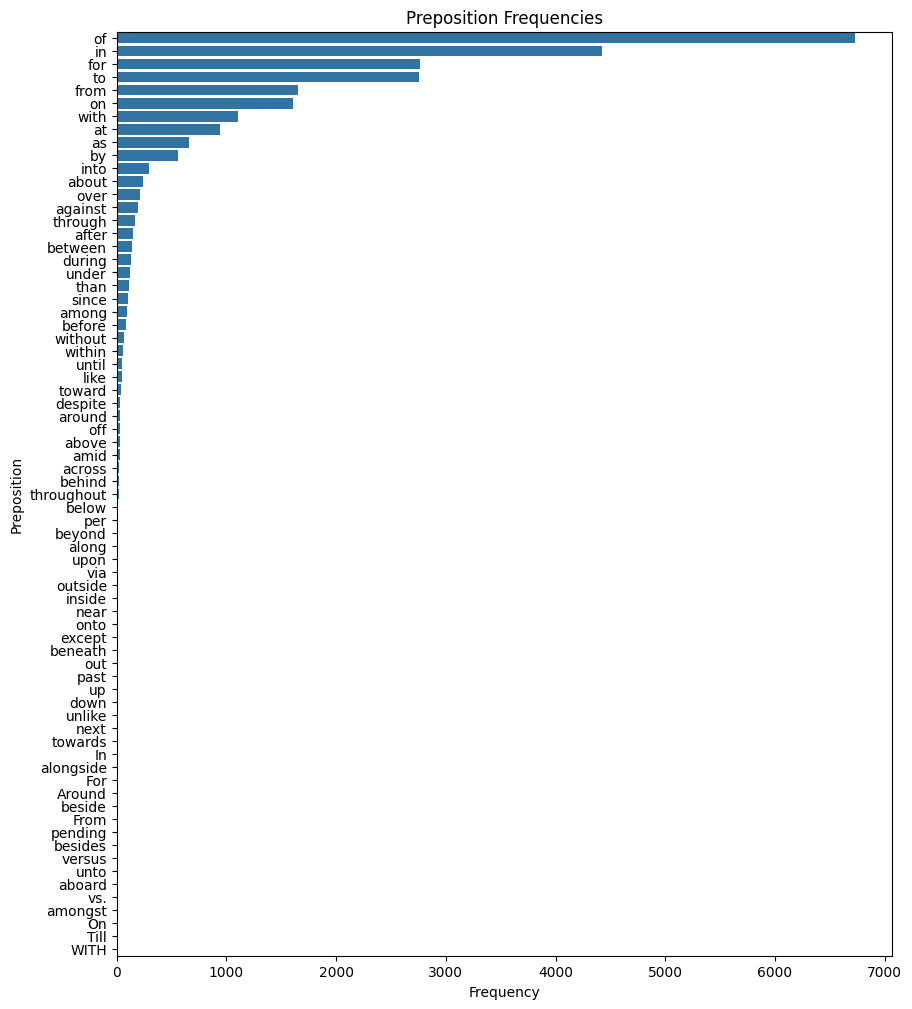

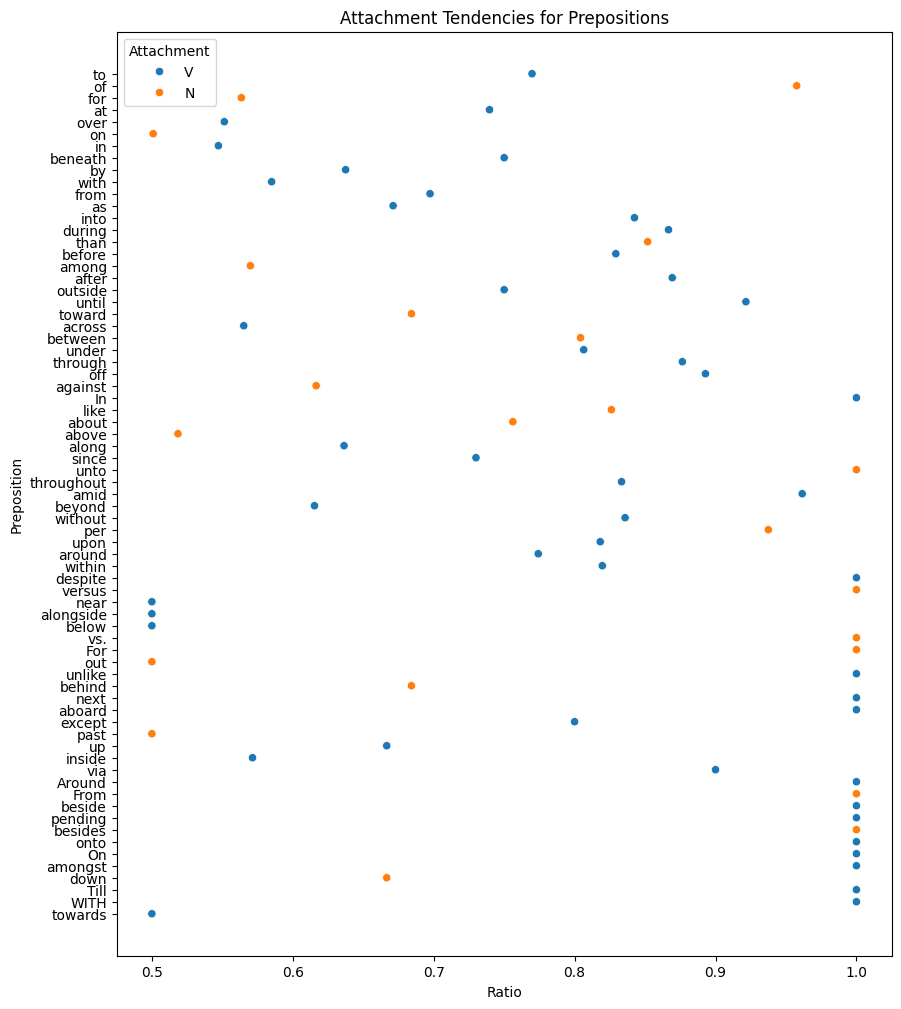

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Plotting the frequency of prepositions
preposition_df = pd.DataFrame(preposition_freq.items(), columns=['Preposition', 'Frequency'])
plt.figure(figsize=(10, 12))
sns.barplot(x='Frequency', y='Preposition', data=preposition_df.sort_values('Frequency', ascending=False))
plt.title('Preposition Frequencies')
plt.show()

# Plotting the attachment tendencies for prepositions
attachment_df = pd.DataFrame.from_dict(attachment_ratio, orient='index', columns=['Attachment', 'Ratio'])
attachment_df = attachment_df.reset_index().rename(columns={'index': 'Preposition'})
plt.figure(figsize=(10, 12))
sns.scatterplot(data=attachment_df, x='Ratio', y='Preposition', hue='Attachment')
plt.title('Attachment Tendencies for Prepositions')
plt.show()